In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error

import joblib

In [2]:
plt.style.use('tableau-colorblind10')
sns.set_style('whitegrid')

In [3]:
df = pd.read_csv('Newfile-Queensfinal.csv', index_col=[0])
df.head()

,Borough,Neighborhood,Building_Class_Category,Tax Class At Present,Block,Lot,Ease-Ment,Building Class At Present,address,Apartment Number,...,Total Units,Land_Square_Feet,Gross Square Feet,Year Built,Tax_Class_At_Time_Of_Sale,Building_Class_At_Time_Of_Sale,Sale_Price,sale date,latitude,longitude
8,4,ARVERNE,01 ONE FAMILY DWELLINGS,1,15830,5,NaN,A6,40-10 ROCKAWAY BEACH BLVD,NaN,...,1,"1,593",482,1920.0,1,A6,0,1/30/2023,40.594336,-73.772407
9,4,ARVERNE,01 ONE FAMILY DWELLINGS,1,15830,5,NaN,A6,40-10 ROCKAWAY BEACH BLVD,NaN,...,1,"1,594",482,1920.0,1,A6,195000,2/3/2022,40.594336,-73.772407
11,4,ARVERNE,01 ONE FAMILY DWELLINGS,1,15830,48,NaN,A5,335 BEACH 40 STREET,NaN,...,1,"2,245","1,350",2005.0,1,A5,0,7/1/2022,40.595162,-73.772415
16,4,ARVERNE,01 ONE FAMILY DWELLINGS,1,15837,27,NaN,A2,354 BEACH 46 STREET,NaN,...,1,"3,804","2,304",1925.0,1,A2,190000,8/19/2022,40.595075,-73.777086
18,4,ARVERNE,01 ONE FAMILY DWELLINGS,1,15839,64,NaN,A2,311 BEACH 47 STREET,NaN,...,1,"2,853","2,080",1920.0,1,A2,0,8/24/2022,40.593872,-73.778278


In [4]:
df['Sale_Price'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.997, 1])


0.000            0.0
0.250            0.0
0.500       650000.0
0.750       999999.0
0.900      1590200.0
0.950      2417750.0
0.990     12031000.0
0.997     43779000.0
1.000    130000000.0
Name: Sale_Price, dtype: float64

In [5]:
df['Year Built'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.997, 1])


0.000    1880.0
0.250    1925.0
0.500    1935.0
0.750    1955.0
0.900    1995.0
0.950    2006.0
0.990    2020.0
0.997    2022.0
1.000    2022.0
Name: Year Built, dtype: float64

In [6]:
mask = (df['Year Built'] > 1900) & (df['Sale_Price'] > 100000) & (df['Sale_Price'] < 1e7)
df = df[mask]

In [7]:
df.shape


(2670, 23)

In [8]:
req_cols = []

for col in df.columns:
    is_na = round(df[col].isna().sum() / len(df) * 100, 2)
    if is_na < 50:
        req_cols.append(col)
    print(f"{col} has {is_na} % of nan values")

print(f"{len(req_cols)} has less than 50% of nan values")
df = df[req_cols]
print(df.shape)

Borough has 0.0 % of nan values
Neighborhood has 0.0 % of nan values
Building_Class_Category has 0.0 % of nan values
Tax Class At Present has 0.0 % of nan values
Block has 0.0 % of nan values
Lot has 0.0 % of nan values
Ease-Ment has 100.0 % of nan values
Building Class At Present has 0.0 % of nan values
address has 0.0 % of nan values
Apartment Number has 99.93 % of nan values
Zip Code has 0.0 % of nan values
Residential_Units has 0.07 % of nan values
Commercial_Units has 0.0 % of nan values
Total Units has 0.0 % of nan values
Land_Square_Feet has 0.07 % of nan values
Gross Square Feet has 0.07 % of nan values
Year Built has 0.0 % of nan values
Tax_Class_At_Time_Of_Sale has 0.0 % of nan values
Building_Class_At_Time_Of_Sale has 0.0 % of nan values
Sale_Price has 0.0 % of nan values
sale date has 0.0 % of nan values
latitude has 0.11 % of nan values
longitude has 0.11 % of nan values
21 has less than 50% of nan values
(2670, 21)


In [9]:
cat_cols = df.select_dtypes('object').columns
k = 0
cardinality_cols = []

for col in cat_cols:
    value_counts = df[col].value_counts(normalize=True).round(2)
    if len(value_counts) > 5 or len(value_counts) < 2:
        cardinality_cols.append(col)
    else:
        print("====================================================================")
        print(col)
        print(value_counts)

cardinality_cols.remove('Neighborhood')
cardinality_cols.remove('Building_Class_At_Time_Of_Sale')
print(f"Removed Columns: {cardinality_cols}")
df.drop(columns=cardinality_cols, axis=1, inplace=True)

Removed Columns: ['Building_Class_Category', 'Tax Class At Present', 'Building Class At Present', 'address', 'Commercial_Units', 'Total Units', 'Land_Square_Feet', 'Gross Square Feet', 'sale date']


In [10]:
df['Neighborhood'].value_counts(normalize=True).round(2)


FLUSHING-NORTH              0.08
RIDGEWOOD                   0.06
BAYSIDE                     0.04
FOREST HILLS                0.04
SPRINGFIELD GARDENS         0.04
RICHMOND HILL               0.04
OZONE PARK                  0.03
FAR ROCKAWAY                0.03
ARVERNE                     0.03
QUEENS VILLAGE              0.03
ELMHURST                    0.03
CORONA                      0.03
SOUTH JAMAICA               0.03
SO. JAMAICA-BAISLEY PARK    0.02
ST. ALBANS                  0.02
LITTLE NECK                 0.02
HOLLIS                      0.02
MIDDLE VILLAGE              0.02
WHITESTONE                  0.02
REGO PARK                   0.02
GLENDALE                    0.02
ASTORIA                     0.02
FLUSHING-SOUTH              0.02
ROSEDALE                    0.02
SOUTH OZONE PARK            0.02
DOUGLASTON                  0.02
COLLEGE POINT               0.02
MASPETH                     0.02
JAMAICA ESTATES             0.02
WOODHAVEN                   0.01
EAST ELMHU

In [11]:
neighborhood = df['Neighborhood'].value_counts(normalize=True).round(2)
idx = np.where(neighborhood > 0.01)[0].max()
places = neighborhood.index[:idx]
df['Neighborhood'] =df['Neighborhood'].apply(lambda x: x if x in places else 'OTHER')
df['Neighborhood'].value_counts(normalize=True)

OTHER                       0.212360
FLUSHING-NORTH              0.075655
RIDGEWOOD                   0.060674
BAYSIDE                     0.038202
SPRINGFIELD GARDENS         0.037079
FOREST HILLS                0.037079
RICHMOND HILL               0.035206
OZONE PARK                  0.033333
FAR ROCKAWAY                0.033333
ARVERNE                     0.030712
QUEENS VILLAGE              0.028839
ELMHURST                    0.027715
CORONA                      0.026592
SOUTH JAMAICA               0.025468
ST. ALBANS                  0.023970
SO. JAMAICA-BAISLEY PARK    0.023970
LITTLE NECK                 0.023596
MIDDLE VILLAGE              0.021723
HOLLIS                      0.021723
WHITESTONE                  0.021348
REGO PARK                   0.020599
GLENDALE                    0.019101
ASTORIA                     0.018727
FLUSHING-SOUTH              0.018352
ROSEDALE                    0.017603
SOUTH OZONE PARK            0.017603
MASPETH                     0.016479
D

In [12]:
building_class = df['Building_Class_At_Time_Of_Sale'].value_counts(normalize=True).round(2)
idx = np.where(building_class > 0.01)[0].max()
places = building_class.index[:idx]
df['Building_Class_At_Time_Of_Sale'] =df['Building_Class_At_Time_Of_Sale'].apply(lambda x: x if x in places else 'OTHER')
df['Building_Class_At_Time_Of_Sale'].value_counts(normalize=True)


A1       0.210487
OTHER    0.153184
A5       0.120974
B2       0.104120
B3       0.090637
A2       0.088390
B1       0.076030
C0       0.067041
S2       0.025468
A0       0.022097
A3       0.021348
C2       0.020225
Name: Building_Class_At_Time_Of_Sale, dtype: float64

In [13]:
df.shape


(2670, 12)

In [14]:
num_cols = df.select_dtypes('number').columns

low_var_cols = []
for col in num_cols:
    scaled = (df[col] - df[col].mean()) / df[col].std()
    variance = scaled.var()
    if variance == 0 or df[col].std() == 0:
        low_var_cols.append(col)
#     else:
#         print(col, variance)

df.drop(columns=low_var_cols, axis=1, inplace=True)
print(f"Removed Columns: {low_var_cols}")
print(df.shape, len(low_var_cols))

Removed Columns: ['Borough']
(2670, 11) 1


In [15]:
df['age'] = 2023 - (df['Year Built'] + df['Year Built']) // 2
df.drop(['Zip Code', 'Year Built'], axis=1, inplace=True)

In [16]:
df

,Neighborhood,Block,Lot,Residential_Units,Tax_Class_At_Time_Of_Sale,Building_Class_At_Time_Of_Sale,Sale_Price,latitude,longitude,age
9,ARVERNE,15830,5,1.0,1,OTHER,195000,40.594336,-73.772407,103.0
16,ARVERNE,15837,27,1.0,1,A2,190000,40.595075,-73.777086,98.0
19,ARVERNE,15849,22,1.0,1,OTHER,542000,40.593978,-73.772070,103.0
20,ARVERNE,15850,30,1.0,1,OTHER,375000,40.593528,-73.773372,103.0
24,ARVERNE,15960,8,1.0,1,A1,146138,40.596140,-73.774547,5.0
...,...,...,...,...,...,...,...,...,...,...
27376,OTHER,1314,24,8.0,2,OTHER,1980000,40.745683,-73.912455,95.0
27565,OTHER,1314,156,2.0,2,OTHER,1000000,40.744439,-73.912980,73.0
27566,OTHER,1330,20,2.0,2,OTHER,1475000,40.743142,-73.907427,92.0
27567,OTHER,1331,33,4.0,2,OTHER,3000000,40.745142,-73.905815,92.0


In [17]:
corr = df.drop('Sale_Price', axis=1).corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.7)]
print(f"columns dropped are: {drop}")
df.drop(columns=drop, axis=1, inplace=True)

columns dropped are: ['latitude']


/var/folders/_w/n6_y432s197g0x74tsw6tp_c0000gn/T/ipykernel_52817/1701191774.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


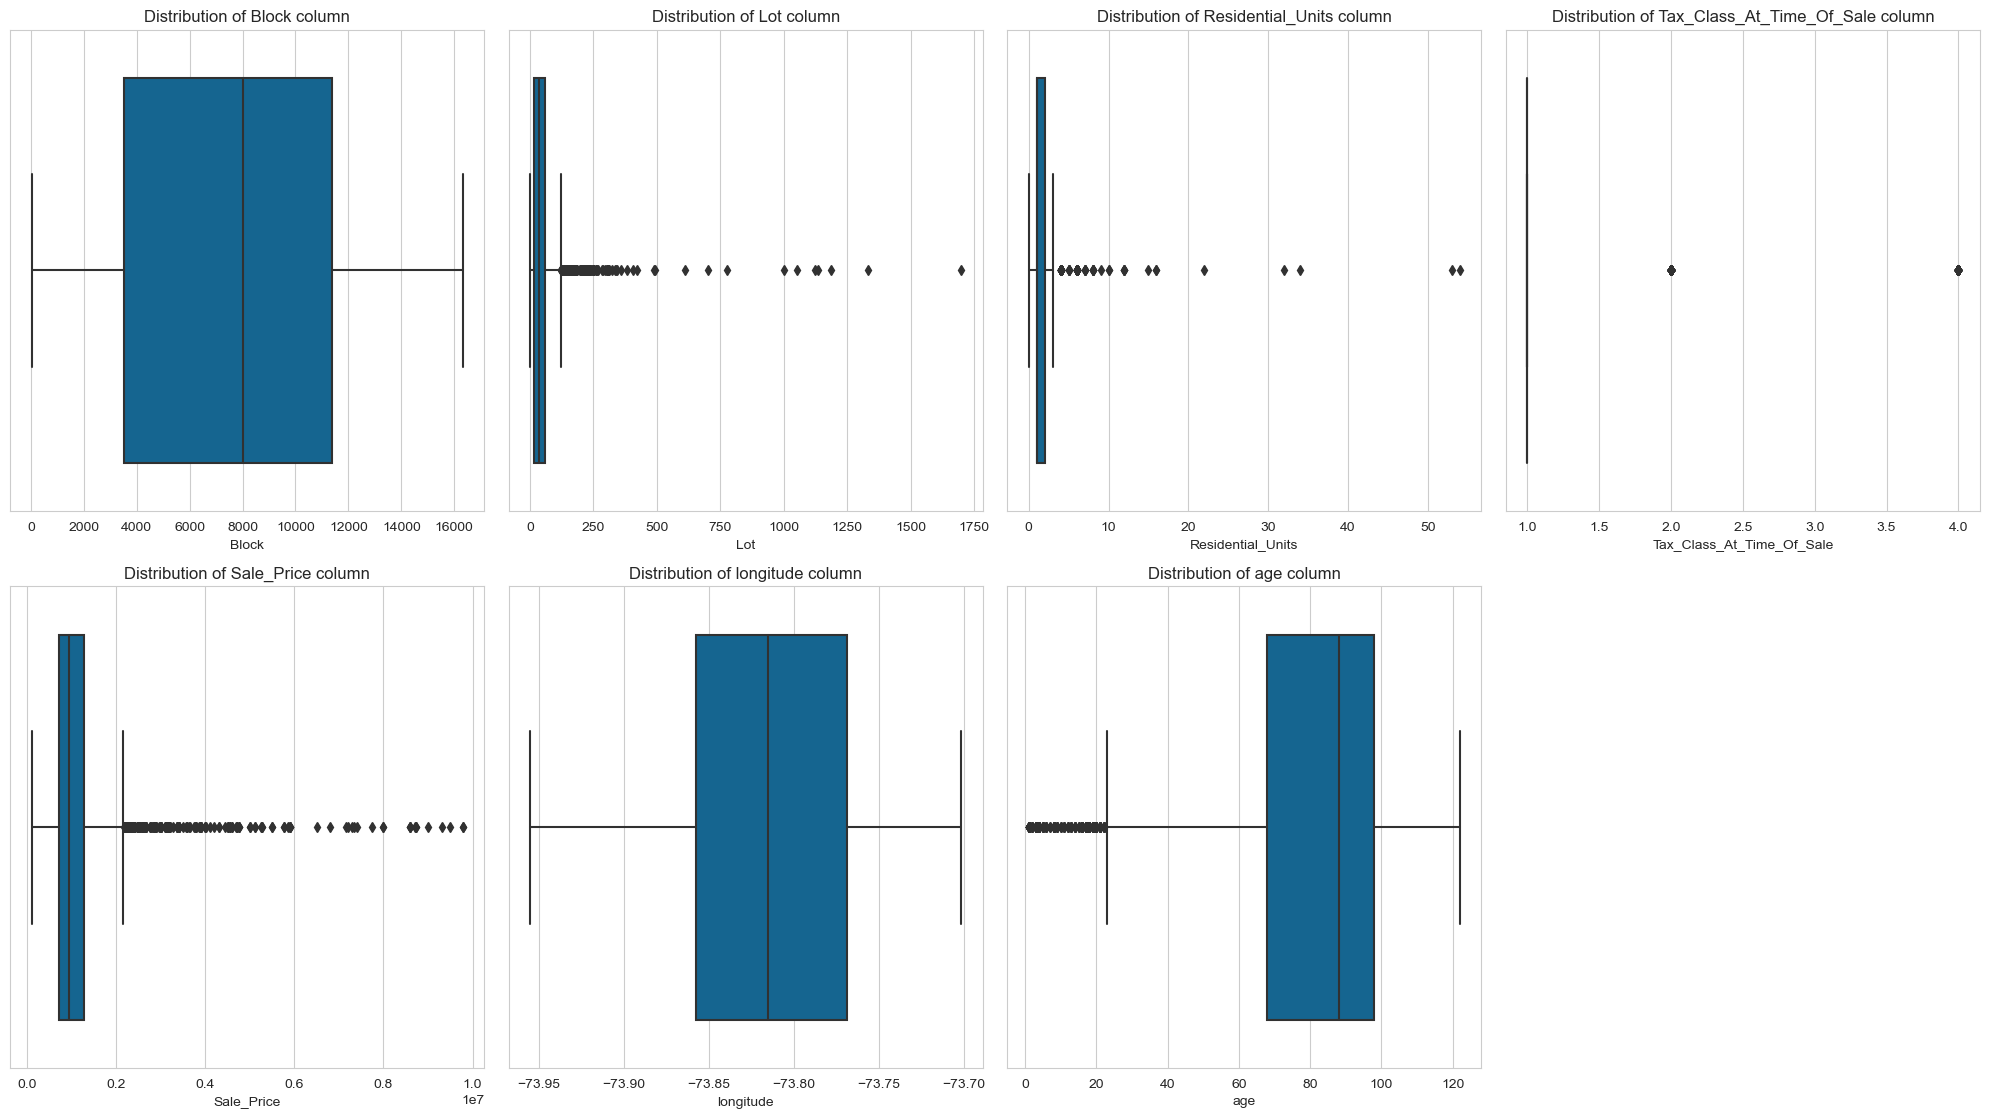

In [18]:
num_cols = df.select_dtypes('number').columns
k = 0
plt.figure(figsize=(20, 100))
for col in num_cols:
    plt.subplot(18, 4, k + 1)
    sns.boxplot(data=df, x=col)
    plt.xlabel(col)
    plt.title(f"Distribution of {col} column")
    k += 1
plt.tight_layout()

<AxesSubplot: >

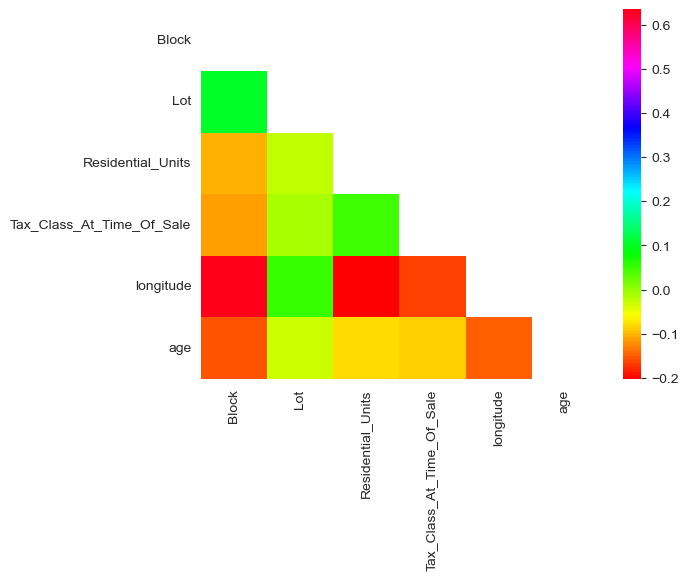

In [19]:
corr = df.drop('Sale_Price', axis=1).corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, cmap='hsv')

In [20]:
df.shape


(2670, 9)

In [21]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2670 entries, 9 to 27597
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Neighborhood                    2670 non-null   object 
 1   Block                           2670 non-null   int64  
 2   Lot                             2670 non-null   int64  
 3   Residential_Units               2668 non-null   float64
 4   Tax_Class_At_Time_Of_Sale       2670 non-null   int64  
 5   Building_Class_At_Time_Of_Sale  2670 non-null   object 
 6   Sale_Price                      2670 non-null   int64  
 7   longitude                       2667 non-null   float64
 8   age                             2670 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 208.6+ KB


In [22]:
drop_cols = ['Block', 'Lot']
df.drop(columns=drop_cols, axis=1, inplace=True)

In [23]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2670 entries, 9 to 27597
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Neighborhood                    2670 non-null   object 
 1   Residential_Units               2668 non-null   float64
 2   Tax_Class_At_Time_Of_Sale       2670 non-null   int64  
 3   Building_Class_At_Time_Of_Sale  2670 non-null   object 
 4   Sale_Price                      2670 non-null   int64  
 5   longitude                       2667 non-null   float64
 6   age                             2670 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 166.9+ KB


In [24]:
df.dropna().info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 9 to 27597
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Neighborhood                    2665 non-null   object 
 1   Residential_Units               2665 non-null   float64
 2   Tax_Class_At_Time_Of_Sale       2665 non-null   int64  
 3   Building_Class_At_Time_Of_Sale  2665 non-null   object 
 4   Sale_Price                      2665 non-null   int64  
 5   longitude                       2665 non-null   float64
 6   age                             2665 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 166.6+ KB


In [25]:
df.dropna(inplace=True)


In [26]:
df.shape


(2665, 7)

In [27]:
def treat_categorical(df):
    cat_cols = df.select_dtypes('object').columns
    k = 0
    cardinality_cols = []
    for col in cat_cols:
        value_counts = df[col].value_counts(normalize=True).round(2)
        if len(value_counts) > 5 or len(value_counts) < 2:
            cardinality_cols.append(col)
    return cardinality_cols

def get_low_variance_cols(df):
    num_cols = df.drop('Sale_Price', axis=1).select_dtypes('number').columns
    low_var_cols = []
    for col in num_cols:
        scaled = (df[col] - df[col].mean()) / df[col].std()
        variance = scaled.var().round(2)
        if variance == 0 or df[col].std() == 0:
            low_var_cols.append(col)
    return low_var_cols

def treat_na(df):
    req_cols = []
    for col in df.columns:
        is_na = round(df[col].isna().sum() / len(df) * 100, 2)
        if is_na < 50:
            req_cols.append(col)
    return req_cols
def wrangle(filepath):
    # Import data
    df = pd.read_csv(filepath, index_col=[0])
    print(f"Imported Data, Shape: {df.shape}")
    
    # Filter out the relevant data by sale_price and year_built
    mask = (df['Year Built'] > 1900) & (df['Sale_Price'] > 100000) & (df['Sale_Price'] < 1e7)
    df = df[mask]
    print(f"Created mask, Shape: {df.shape}")
    
    # Remove features which have majority missing values
    req_cols = treat_na(df)
    df = df[req_cols]
    print(f"Filtered Columns by NaN, Shape: {df.shape}")
    
    # Remove high and low cardinality categorical columns
    drop_cols = treat_categorical(df)
    if 'Neighborhood' in drop_cols:
        drop_cols.remove('Neighborhood')
    if 'Building_Class_At_Time_Of_Sale' in drop_cols:
        drop_cols.remove('Building_Class_At_Time_Of_Sale')
    df.drop(columns=drop_cols, axis=1, inplace=True)
    print(f"Dropped Columns by Cardinality, Shape: {df.shape}")
    
    # Reduce the cardinality of neighborhood column
    neighborhood = df['Neighborhood'].value_counts(normalize=True).round(2)
    idx = np.where(neighborhood > 0.01)[0].max()
    places = neighborhood.index[:idx]
    df['Neighborhood'] =df['Neighborhood'].apply(lambda x: x if x in places else 'OTHER')
    
    # Reduce the cardinality of building_class_at_sale column
    building_class = df['Building_Class_At_Time_Of_Sale'].value_counts(normalize=True).round(2)
    idx = np.where(building_class > 0.01)[0].max()
    places = building_class.index[:idx]
    df['Building_Class_At_Time_Of_Sale'] =df['Building_Class_At_Time_Of_Sale'].apply(lambda x: x if x in places else 'OTHER')
    
    
    # Calculate age of the house
    df['age'] = 2023 - (df['Year Built'] + df['Year Built']) // 2
    
    # Drop unwanted columns
    drop = ['Zip Code', 'Year Built']
    df.drop(columns=drop, axis=1, inplace=True)
    print(f"Dropped Columns by redundancy, Shape: {df.shape}")
    
    # Drop columns with multicollinearity
    corr = df.drop('Sale_Price', axis=1).corr()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.7)]
    df.drop(columns=drop, axis=1, inplace=True)
    print(f"Dropped Columns by collinearity, Shape: {df.shape}")
    
    # Drop unwanted columns
    drop_cols = ['Block', 'Lot']
    df.drop(columns=drop_cols, axis=1, inplace=True)
    print(f"Dropped Columns manually, Shape: {df.shape}")
    
    # Drop missing values
    df.dropna(inplace=True)
    print(f"Dropped NaN values, Shape: {df.shape}")
    
    return df

In [28]:
Queens = wrangle('Newfile-Queensfinal.csv')
print(Queens.shape)
Queens.head()

Imported Data, Shape: (4470, 23)
Created mask, Shape: (2670, 23)
Filtered Columns by NaN, Shape: (2670, 21)
Dropped Columns by Cardinality, Shape: (2670, 12)
Dropped Columns by redundancy, Shape: (2670, 11)
Dropped Columns by collinearity, Shape: (2670, 10)
Dropped Columns manually, Shape: (2670, 8)
Dropped NaN values, Shape: (2665, 8)
(2665, 8)


/var/folders/_w/n6_y432s197g0x74tsw6tp_c0000gn/T/ipykernel_52817/2847416709.py:75: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))


,Borough,Neighborhood,Residential_Units,Tax_Class_At_Time_Of_Sale,Building_Class_At_Time_Of_Sale,Sale_Price,longitude,age
9,4,ARVERNE,1.0,1,OTHER,195000,-73.772407,103.0
16,4,ARVERNE,1.0,1,A2,190000,-73.777086,98.0
19,4,ARVERNE,1.0,1,OTHER,542000,-73.772070,103.0
20,4,ARVERNE,1.0,1,OTHER,375000,-73.773372,103.0
24,4,ARVERNE,1.0,1,A1,146138,-73.774547,5.0


In [29]:
Queens.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 9 to 27597
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Borough                         2665 non-null   int64  
 1   Neighborhood                    2665 non-null   object 
 2   Residential_Units               2665 non-null   float64
 3   Tax_Class_At_Time_Of_Sale       2665 non-null   int64  
 4   Building_Class_At_Time_Of_Sale  2665 non-null   object 
 5   Sale_Price                      2665 non-null   int64  
 6   longitude                       2665 non-null   float64
 7   age                             2665 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 187.4+ KB


In [30]:
viz_df = Queens.copy()


In [31]:
df['Sale_Price'] = df['Sale_Price'].astype(np.float64)
print(df.dtypes)

Neighborhood                       object
Residential_Units                 float64
Tax_Class_At_Time_Of_Sale           int64
Building_Class_At_Time_Of_Sale     object
Sale_Price                        float64
longitude                         float64
age                               float64
dtype: object


In [32]:
median_home_price = viz_df['Sale_Price'].median()
median_home_price

940000.0

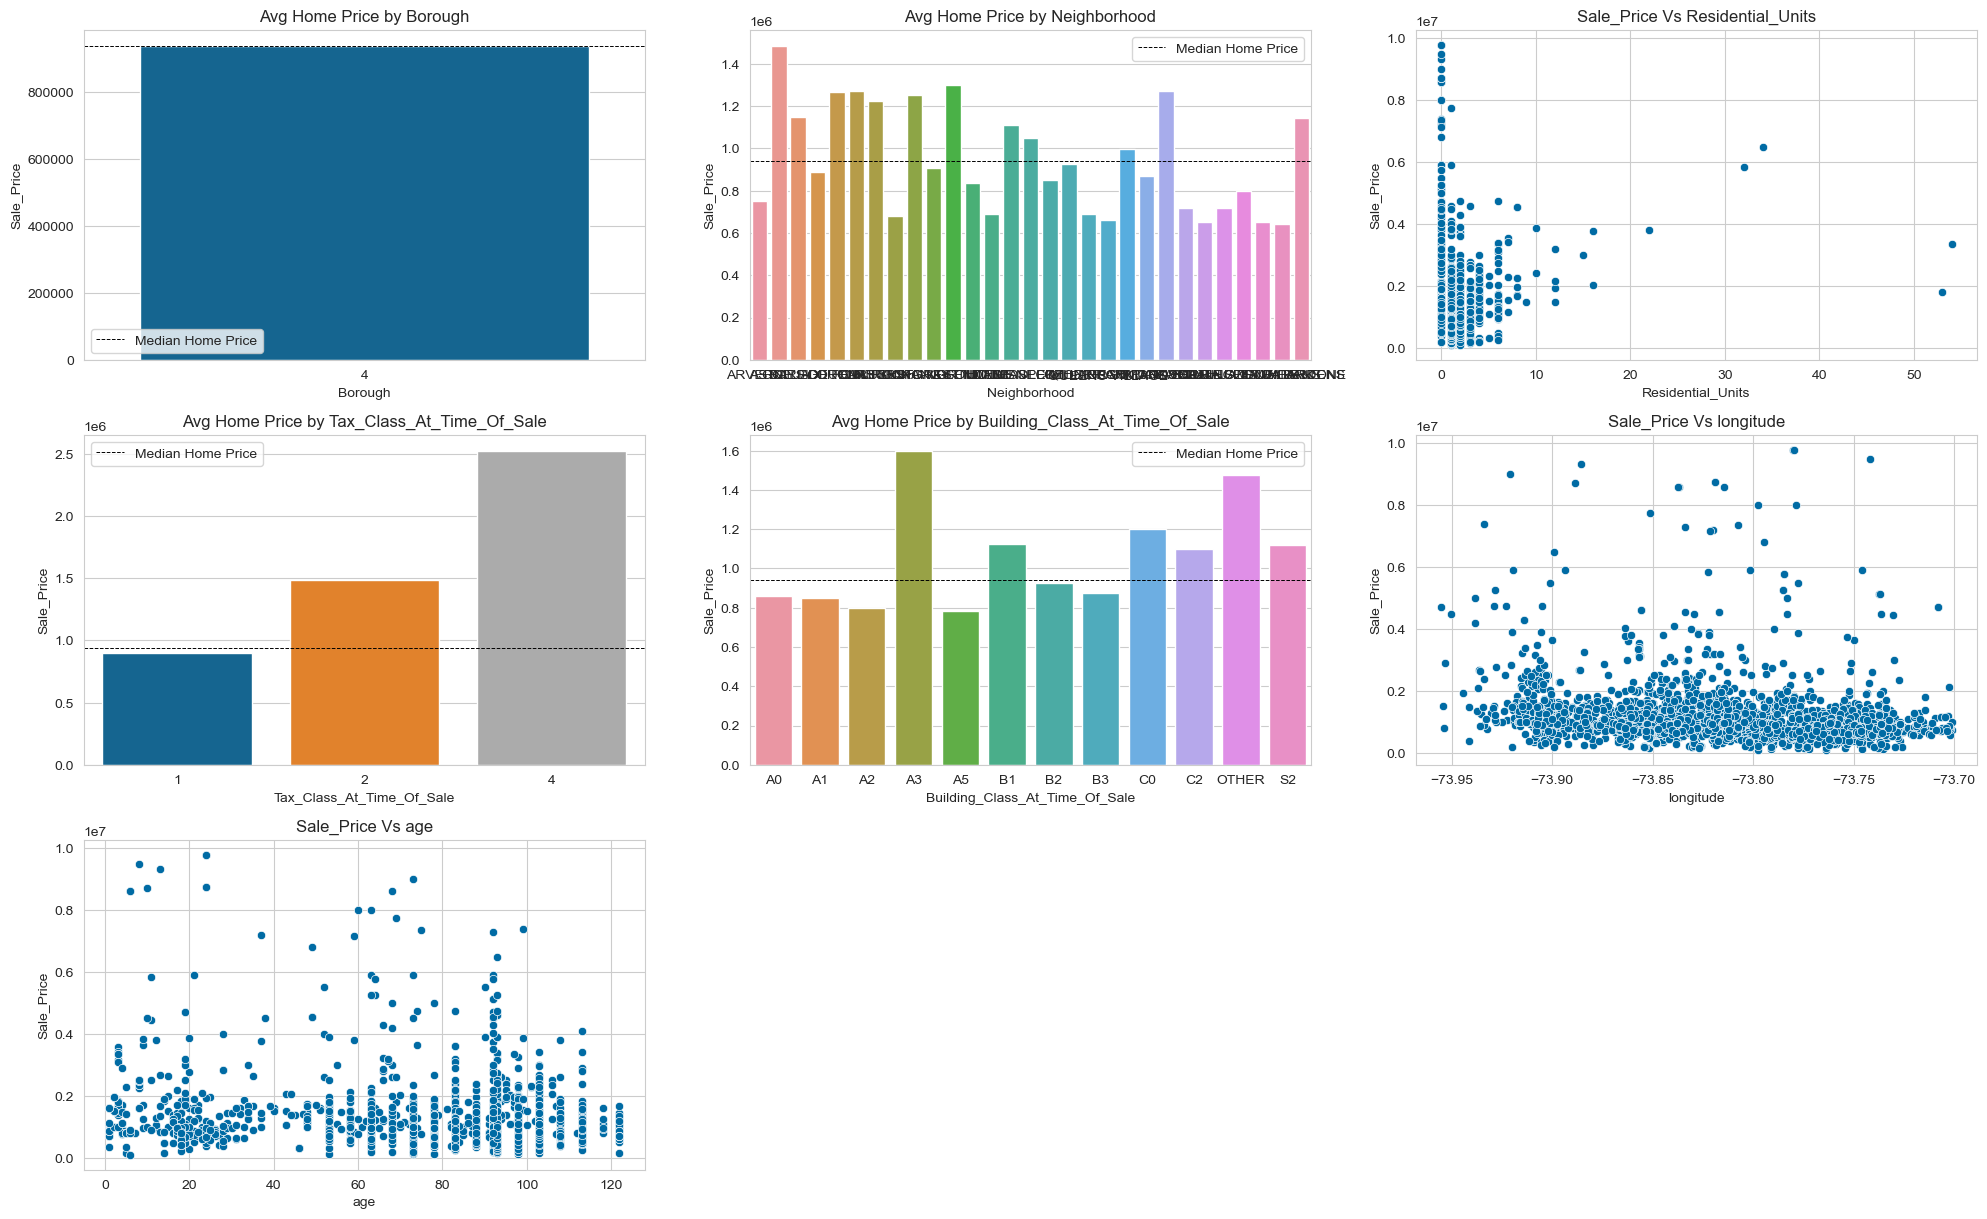

In [33]:
k = 0
plt.figure(figsize=(20, 20))
for col in viz_df.drop('Sale_Price', axis=1).columns:
    plt.subplot(5, 3, k + 1)
    if viz_df[col].dtype == 'float64':
        sns.scatterplot(data=viz_df, x=col, y='Sale_Price')
        plt.title(f"Sale_Price Vs {col}")
    else:
        group = viz_df[[col, 'Sale_Price']].groupby(by=col).median()
        sns.barplot(data=group, x=group.index, y='Sale_Price')
        plt.axhline(y=median_home_price, label='Median Home Price', color='black', linestyle='--', linewidth=0.7)
        plt.title(f"Avg Home Price by {col}")
        plt.legend()
    k += 1
plt.tight_layout()


<AxesSubplot: xlabel='Sale_Price', ylabel='Count'>

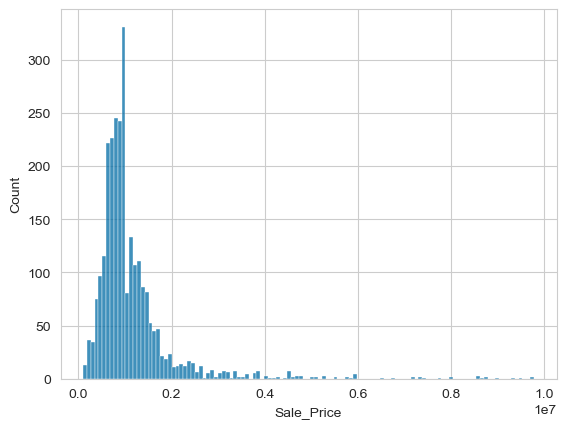

In [34]:
sns.histplot(viz_df['Sale_Price'])


<AxesSubplot: xlabel='Sale_Price', ylabel='Count'>

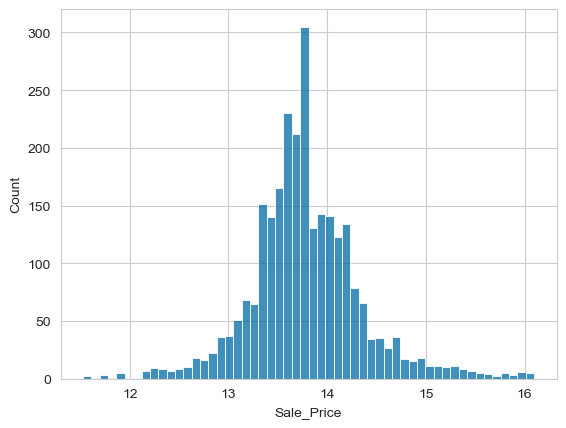

In [35]:
sns.histplot(np.log(viz_df['Sale_Price']))


In [36]:
X_train, X_test, y_train, y_test = train_test_split(Queens.drop('Sale_Price', axis=1), Queens['Sale_Price'], 
                                                    test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2132, 7), (533, 7), (2132,), (533,))

In [37]:
y_mean = Queens['Sale_Price'].mean()
print("Baseline R2 Score:", r2_score(y_test, [y_mean] * len(y_test)))
print("Baseline Root Mean Squared Error:", mean_squared_error(y_test, [y_mean] * len(y_test), squared=False))

Baseline R2 Score: -0.0015864710611603883
Baseline Root Mean Squared Error: 1022310.4570820561


In [38]:
def train_model(model):
    model.fit(X_train, np.log(y_train))
    print(f"Train R-Squared: {r2_score(y_train, np.exp(model.predict(X_train))).round(2)}")
    print(f"Test R-Squared: {r2_score(y_test, np.exp(model.predict(X_test))).round(2)}")
    print(f"Train Root Mean Squared Error: {mean_squared_error(y_train, np.exp(model.predict(X_train)), squared=False).round(2)}")
    print(f"Test Root Mean Squared Error: {mean_squared_error(y_test, np.exp(model.predict(X_test)), squared=False).round(2)}")
    return model

In [39]:
X_train.columns

Index(['Borough', 'Neighborhood', 'Residential_Units',
       'Tax_Class_At_Time_Of_Sale', 'Building_Class_At_Time_Of_Sale',
       'longitude', 'age'],
      dtype='object')

In [40]:
rf = make_pipeline(
    TargetEncoder(),
    RobustScaler(),
    RandomForestRegressor(random_state=42, n_jobs=-1)
)
rf = train_model(rf)

Train R-Squared: 0.9
Test R-Squared: 0.55
Train Root Mean Squared Error: 301376.69
Test Root Mean Squared Error: 685680.12


In [41]:
params = {
    'randomforestregressor__n_estimators': np.arange(25, 126, 25),
    'randomforestregressor__min_samples_split': np.arange(2, 26, 5)
}
rf_grid = RandomizedSearchCV(
    estimator = rf,
    param_distributions=params,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)
rf_grid = train_model(rf_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Train R-Squared: 0.73
Test R-Squared: 0.53
Train Root Mean Squared Error: 499630.57
Test Root Mean Squared Error: 698391.8


In [42]:
rf_grid.best_estimator_


Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['Neighborhood',
                                     'Building_Class_At_Time_Of_Sale'])),
                ('robustscaler', RobustScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(min_samples_split=12, n_jobs=-1,
                                       random_state=42))])

In [43]:
xgb = make_pipeline(
    TargetEncoder(),
    RobustScaler(),
    XGBRegressor(random_state=42, n_jobs=-1),
)
xgb = train_model(xgb)

Train R-Squared: 0.95
Test R-Squared: 0.64
Train Root Mean Squared Error: 222720.18
Test Root Mean Squared Error: 617011.81


In [44]:
cat = CatBoostRegressor(
    cat_features=list(X_train.select_dtypes('object').columns),
    verbose=0
)
cat = train_model(cat)

Train R-Squared: 0.73
Test R-Squared: 0.58
Train Root Mean Squared Error: 500027.9
Test Root Mean Squared Error: 663136.13


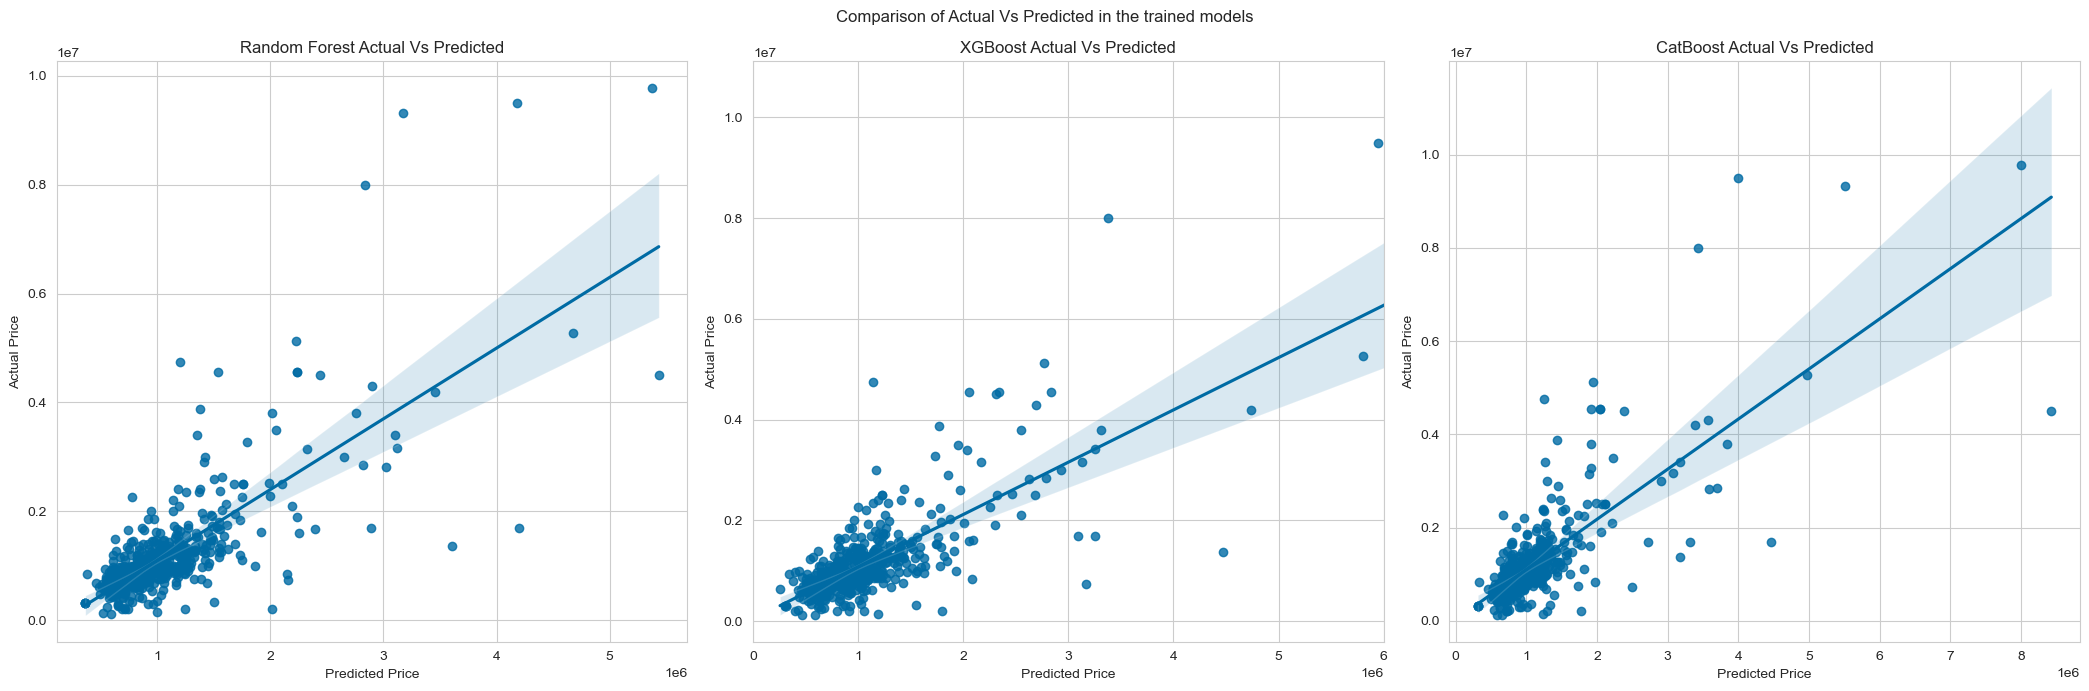

In [45]:
plt.figure(figsize=(21, 7))
plt.subplot(1, 3, 1)
preds = np.exp(rf_grid.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Random Forest Actual Vs Predicted');

plt.subplot(1, 3, 2)
preds = np.exp(xgb.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlim(0, 6e6)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('XGBoost Actual Vs Predicted');

plt.subplot(1, 3, 3)
preds = np.exp(cat.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('CatBoost Actual Vs Predicted');

plt.suptitle('Comparison of Actual Vs Predicted in the trained models')
plt.tight_layout()


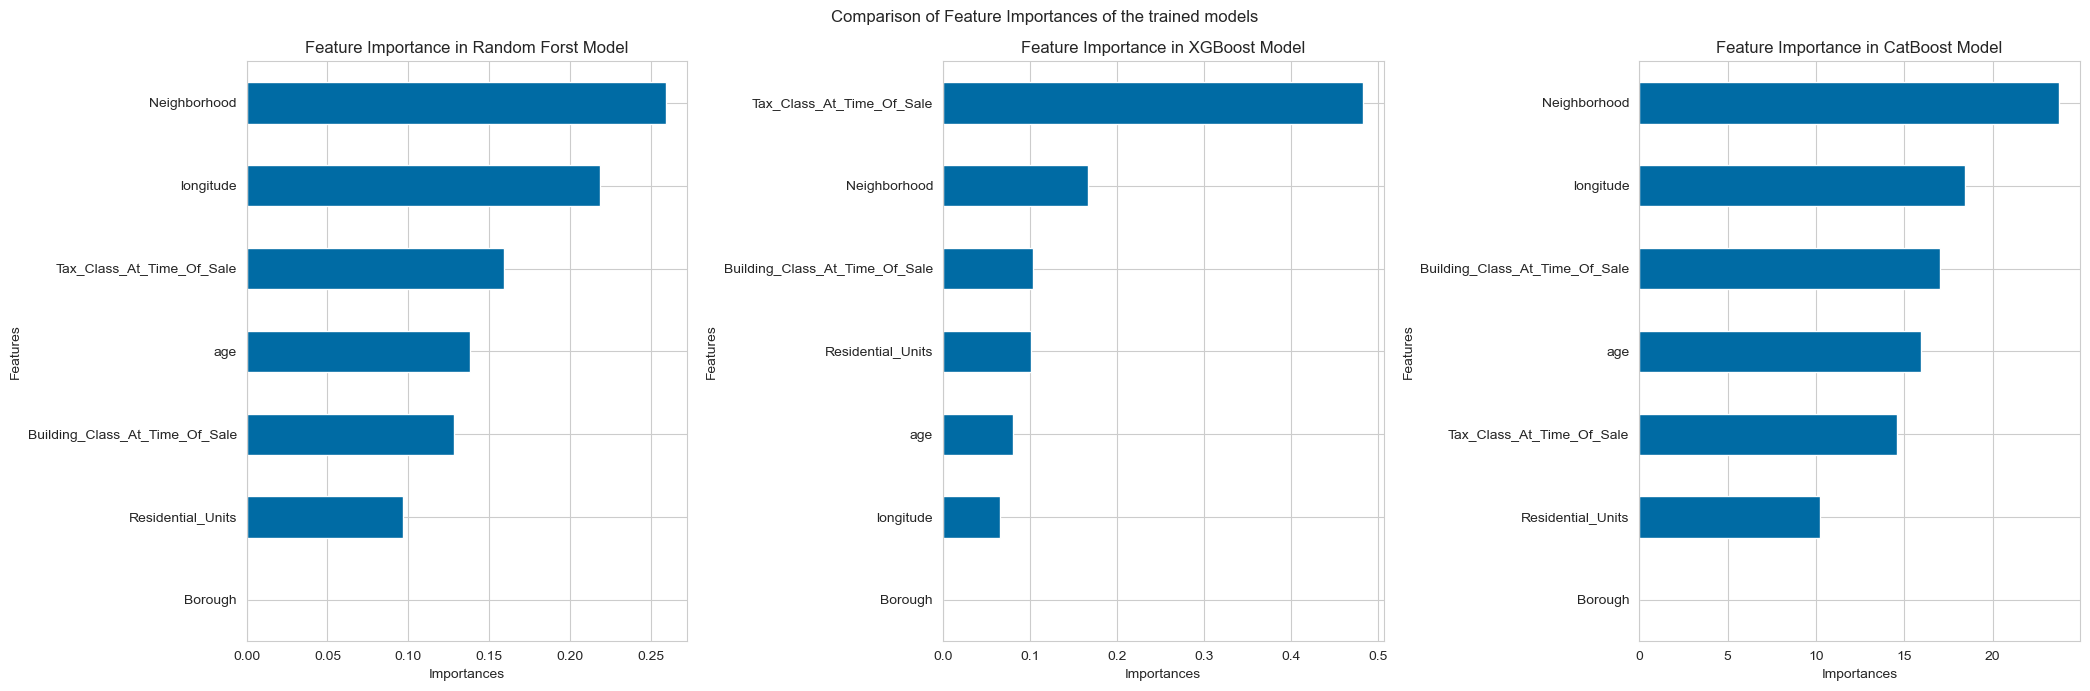

In [46]:
plt.figure(figsize=(21, 7))
feat_imp = rf_grid.best_estimator_.named_steps['randomforestregressor'].feature_importances_
rf_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 1)
rf_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forst Model');

feat_imp = xgb.named_steps['xgbregressor'].feature_importances_
xgb_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 2)
xgb_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in XGBoost Model');

feat_imp = cat.get_feature_importance()
cat_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 3)
cat_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in CatBoost Model')

plt.suptitle('Comparison of Feature Importances of the trained models')
plt.tight_layout();

In [91]:
joblib.dump(rf_grid, 'randomforest.pkl', compress=9)
joblib.dump(xgb, 'xgboost.pkl', compress=9)
joblib.dump(cat, 'catboost.pkl', compress=9)

['catboost.pkl']

In [92]:
def predict_house_price(Borough, Neighborhood, Residential_Units, Tax_Class_At_Time_Of_Sale, Building_Class_At_Time_Of_Sale,
       longitude, age):
    
    params_dict = {
        'Borough': Borough,
        'Neighborhood': Neighborhood,
        'Residential_Units': Residential_Units,
        'Tax_Class_At_Time_Of_Sale': Tax_Class_At_Time_Of_Sale,
        'Building_Class_At_Time_Of_Sale': Building_Class_At_Time_Of_Sale,
        'longitude': longitude,
        'age': age
    }
    
    df = pd.DataFrame(params_dict, index=[0])
    
    with open('xgboost.pkl', 'rb') as f:
        xgb = joblib.load(f)
        
    xgb_pred = xgb.predict(df)
    
    avg = (np.exp(xgb_pred)).round(2)[0]
    
    return f"The Predicted House Price is ${avg}"

In [93]:
X_train.columns

Index(['Borough', 'Neighborhood', 'Residential_Units',
       'Tax_Class_At_Time_Of_Sale', 'Building_Class_At_Time_Of_Sale',
       'longitude', 'age'],
      dtype='object')

In [94]:
predict_house_price(
    Borough = 4,
    Neighborhood = 	'ARVERNE',
    Residential_Units = 1, 
    Tax_Class_At_Time_Of_Sale = 1,
    Building_Class_At_Time_Of_Sale = 'OTHER',
    longitude = -73.7724074,
    age = 112
)

#Borough: 
#Neighborhood:
#Residential_Units: 
#Tax_Class_At_Time_Of_Sale: 
#Building_Class_At_Time_Of_Sale: 
#longitude: 
#age: 

'The Predicted House Price is $346991.71875'

In [95]:
predict_house_price(
    Borough = 4,
    Neighborhood = 'ASTORIA',
    Residential_Units = 1, 
    Tax_Class_At_Time_Of_Sale = 1,
    Building_Class_At_Time_Of_Sale = 'OTHER',
    longitude = -73.9074312,
    age = 112
)

'The Predicted House Price is $1155899.25'

In [96]:
def predict_house_price(Borough, Neighborhood, Residential_Units, Tax_Class_At_Time_Of_Sale, Building_Class_At_Time_Of_Sale,
       longitude, age):
    
    params_dict = {
        'Borough': Borough,
        'Neighborhood': Neighborhood,
        'Residential_Units': Residential_Units,
        'Tax_Class_At_Time_Of_Sale': Tax_Class_At_Time_Of_Sale,
        'Building_Class_At_Time_Of_Sale': Building_Class_At_Time_Of_Sale,
        'longitude': longitude,
        'age': age
    }
    
    df = pd.DataFrame(params_dict, index=[0])
    
    with open('randomforest.pkl', 'rb') as f:
        rf_grid = joblib.load(f)
        
    rf_grid_pred = rf_grid.predict(df)
    
    avg = (np.exp(rf_grid_pred)).round(2)[0]
    
    return f"The Predicted House Price is ${avg}"

In [97]:
predict_house_price(
    Borough = 4,
    Neighborhood = 'BAYSIDE',
    Residential_Units = 1, 
    Tax_Class_At_Time_Of_Sale = 1,
    Building_Class_At_Time_Of_Sale = 'OTHER',
    longitude = -73.790279,
    age = 112
)

'The Predicted House Price is $1139969.32'

In [100]:
def predict_house_price(Borough, Neighborhood, Residential_Units,
       Tax_Class_At_Time_Of_Sale, Building_Class_At_Time_Of_Sale,
       longitude, age):
    
    params_dict = {
        'Borough': Borough,
        'Neighborhood': Neighborhood,
        'Residential_Units': Residential_Units,
        'Tax_Class_At_Time_Of_Sale': Tax_Class_At_Time_Of_Sale,
        'Building_Class_At_Time_Of_Sale': Building_Class_At_Time_Of_Sale,
        'longitude': longitude,
        'age': age
    }
    
    df = pd.DataFrame(params_dict, index=[0])
    
    with open('catboost.pkl', 'rb') as f:
        cat = joblib.load(f)
        
    cat_pred = cat.predict(df)
    
    avg = (np.exp(cat_pred)).round(2)[0]
    
    return f"The Predicted House Price is ${avg}"

In [101]:
predict_house_price(
    Borough = 4,
    Neighborhood = 'BEECHHURST',
    Residential_Units = 1, 
    Tax_Class_At_Time_Of_Sale = 1,
    Building_Class_At_Time_Of_Sale = 'OTHER',
    longitude = -73.8032822,
    age = 112
)

'The Predicted House Price is $739656.84'